#Load Library

In [2]:
#import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML
from tensorflow.keras.optimizers import RMSprop

#Load Dataset

In [3]:
# Mendefinisikan path direktori utama di mana dataset berada
sdir = r'C:\Users\SIC5\FinalProject\DeteksiHama\Dataset'

# Mendefinisikan dua daftar kosong untuk menyimpan file path dan label
filepaths = []
labels = []

# Membuat daftar nama subdirektori (kelas) dalam direktori utama
classlist = os.listdir(sdir)

# Melakukan iterasi melalui setiap kelas dalam classlist
for klass in classlist:
    # Membuat path lengkap untuk setiap kelas
    classpath = os.path.join(sdir, klass)
    # Memeriksa apakah path tersebut adalah direktori
    if os.path.isdir(classpath):
        # Membuat daftar semua file dalam subdirektori saat ini
        flist = os.listdir(classpath)
        # Melakukan iterasi kedua untuk setiap file dalam subdirektori
        for f in flist:
            # Membuat path lengkap untuk setiap file
            fpath = os.path.join(classpath, f)
            # Menambahkan path file ke daftar filepaths
            filepaths.append(fpath)
            # Menambahkan nama kelas ke daftar labels
            labels.append(klass)

# Membuat pandas Series dari daftar filepaths dengan nama kolom 'filepaths'
Fseries = pd.Series(filepaths, name='filepaths')

# Membuat pandas Series dari daftar labels dengan nama kolom 'labels'
Lseries = pd.Series(labels, name='labels')

# Menggabungkan kedua Series menjadi sebuah DataFrame dengan dua kolom
df = pd.concat([Fseries, Lseries], axis=1)

# Menampilkan lima baris pertama dari DataFrame
print(df.head())

# Menampilkan jumlah kemunculan setiap label dalam kolom 'labels'
print(df['labels'].value_counts())


                                           filepaths              labels
0  C:\Users\SIC5\FinalProject\DeteksiHama\Dataset...  Data Sawi Ada Hama
1  C:\Users\SIC5\FinalProject\DeteksiHama\Dataset...  Data Sawi Ada Hama
2  C:\Users\SIC5\FinalProject\DeteksiHama\Dataset...  Data Sawi Ada Hama
3  C:\Users\SIC5\FinalProject\DeteksiHama\Dataset...  Data Sawi Ada Hama
4  C:\Users\SIC5\FinalProject\DeteksiHama\Dataset...  Data Sawi Ada Hama
labels
Data Sawi Ada Hama      500
Data Sawi Tanpa Hama    500
Name: count, dtype: int64


#Pembagian Dataset

In [4]:
# Menentukan proporsi data untuk training
split_train = 0.8

# Menentukan proporsi data untuk testing
split_test = 0.1

# Menghitung proporsi data dummy yang akan digunakan untuk memisahkan data testing dan validasi
dummy_split = split_test / (1 - split_train)

# Memisahkan data menjadi data training dan dummy data (gabungan data testing dan validasi)
df_train, df_dummy = train_test_split(df, train_size=split_train, shuffle=True, random_state=123)

# Memisahkan dummy data menjadi data testing dan data validasi
df_test, df_valid = train_test_split(df_dummy, train_size=dummy_split, shuffle=True, random_state=123)

# Mencetak panjang data training, data testing, dan data validasi
print('train_df length: ', len(df_train), '  test_df length: ', len(df_test), '  valid_df length: ', len(df_valid))


train_df length:  800   test_df length:  100   valid_df length:  100


#Pengaturan dan Pembuatan Generator Data

In [5]:
# Menentukan tinggi dan lebar gambar
height = 128
width = 128

# Menentukan jumlah saluran warna (RGB)
channels = 3

# Menentukan ukuran batch untuk pelatihan
batch_size = 64

# Menentukan bentuk gambar sebagai tuple (tinggi, lebar, saluran)
img_shape = (height, width, channels)

# Menentukan ukuran gambar sebagai tuple (tinggi, lebar)
img_size = (height, width)

# Mendapatkan panjang (jumlah sampel) dari data pengujian
length = len(df_test)

# Menghitung ukuran batch untuk pengujian yang memenuhi kondisi:
# 1. Jumlah batch adalah pembagi dari panjang data pengujian
# 2. Ukuran batch tidak melebihi 80
# 3. Memilih ukuran batch terbesar yang memenuhi kondisi di atas
test_batch_size = sorted([int(length/n) for n in range(1, length + 1) if length % n == 0 and length/n <= 80], reverse=True)[0]

# Menghitung jumlah langkah (steps) untuk pengujian
test_steps = int(length / test_batch_size)

# Mencetak ukuran batch untuk pengujian dan jumlah langkah untuk pengujian
print('test batch size: ', test_batch_size, '  test steps: ', test_steps)

# Membuat generator gambar dengan normalisasi piksel (rescale) dari 0-255 menjadi 0-1
gen = ImageDataGenerator(rescale=1./255)

# Membuat generator data pelatihan dari DataFrame
train_gen = gen.flow_from_dataframe(df_train, x_col='filepaths', y_col='labels', target_size=img_size, 
                                    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Membuat generator gambar untuk validasi dengan normalisasi piksel (rescale)
validgen = ImageDataGenerator(rescale=1./255)

# Membuat generator data validasi dari DataFrame
valid_gen = validgen.flow_from_dataframe(df_valid, x_col='filepaths', y_col='labels', target_size=img_size, 
                                         class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

# Membuat generator gambar untuk pengujian dengan normalisasi piksel (rescale)
testgen = ImageDataGenerator(rescale=1./255)

# Membuat generator data pengujian dari DataFrame
test_gen = testgen.flow_from_dataframe(df_test, x_col='filepaths', y_col='labels', target_size=img_size, 
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# Mendapatkan daftar nama kelas dari generator data pelatihan
classes = list(train_gen.class_indices.keys())

# Mencetak daftar nama kelas
print(classes)

# Menghitung jumlah kelas
class_count = len(classes)

test batch size:  50   test steps:  2
Found 799 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
['Data Sawi Ada Hama', 'Data Sawi Tanpa Hama']


d:\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


#Pembuatan fungsi Visualisasi Contoh Gambar dari Generator

In [6]:
# Fungsi untuk menampilkan contoh gambar dari generator
def show_image_samples(gen):
    # Mendapatkan dictionary yang berisi indeks kelas dari generator pengujian
    test_dict = test_gen.class_indices

    # Mendapatkan daftar nama kelas dari dictionary
    classes = list(test_dict.keys())

    # Mengambil satu batch sampel gambar dan label dari generator
    images, labels = next(gen)

    # Menentukan ukuran figure untuk plot
    plt.figure(figsize=(20, 20))

    # Mendapatkan panjang (jumlah) label dalam batch
    length = len(labels)

    # Menentukan jumlah gambar yang akan ditampilkan, maksimal 25
    if length < 25:
        r = length
    else:
        r = 25

    # Loop untuk menampilkan setiap gambar dalam batch
    for i in range(r):
        # Menambahkan subplot pada posisi tertentu
        plt.subplot(5, 5, i + 1)

        # Mendapatkan gambar dari batch
        image = images[i]

        # Menampilkan gambar
        plt.imshow(image)

        # Mendapatkan indeks kelas dari label yang diprediksi
        index = np.argmax(labels[i])

        # Mendapatkan nama kelas berdasarkan indeks
        class_name = classes[index]

        # Menambahkan judul pada gambar dengan nama kelas
        plt.title(class_name, color='blue', fontsize=16)

        # Menghapus sumbu gambar
        plt.axis('off')

    # Menampilkan plot dengan semua gambar
    plt.show()


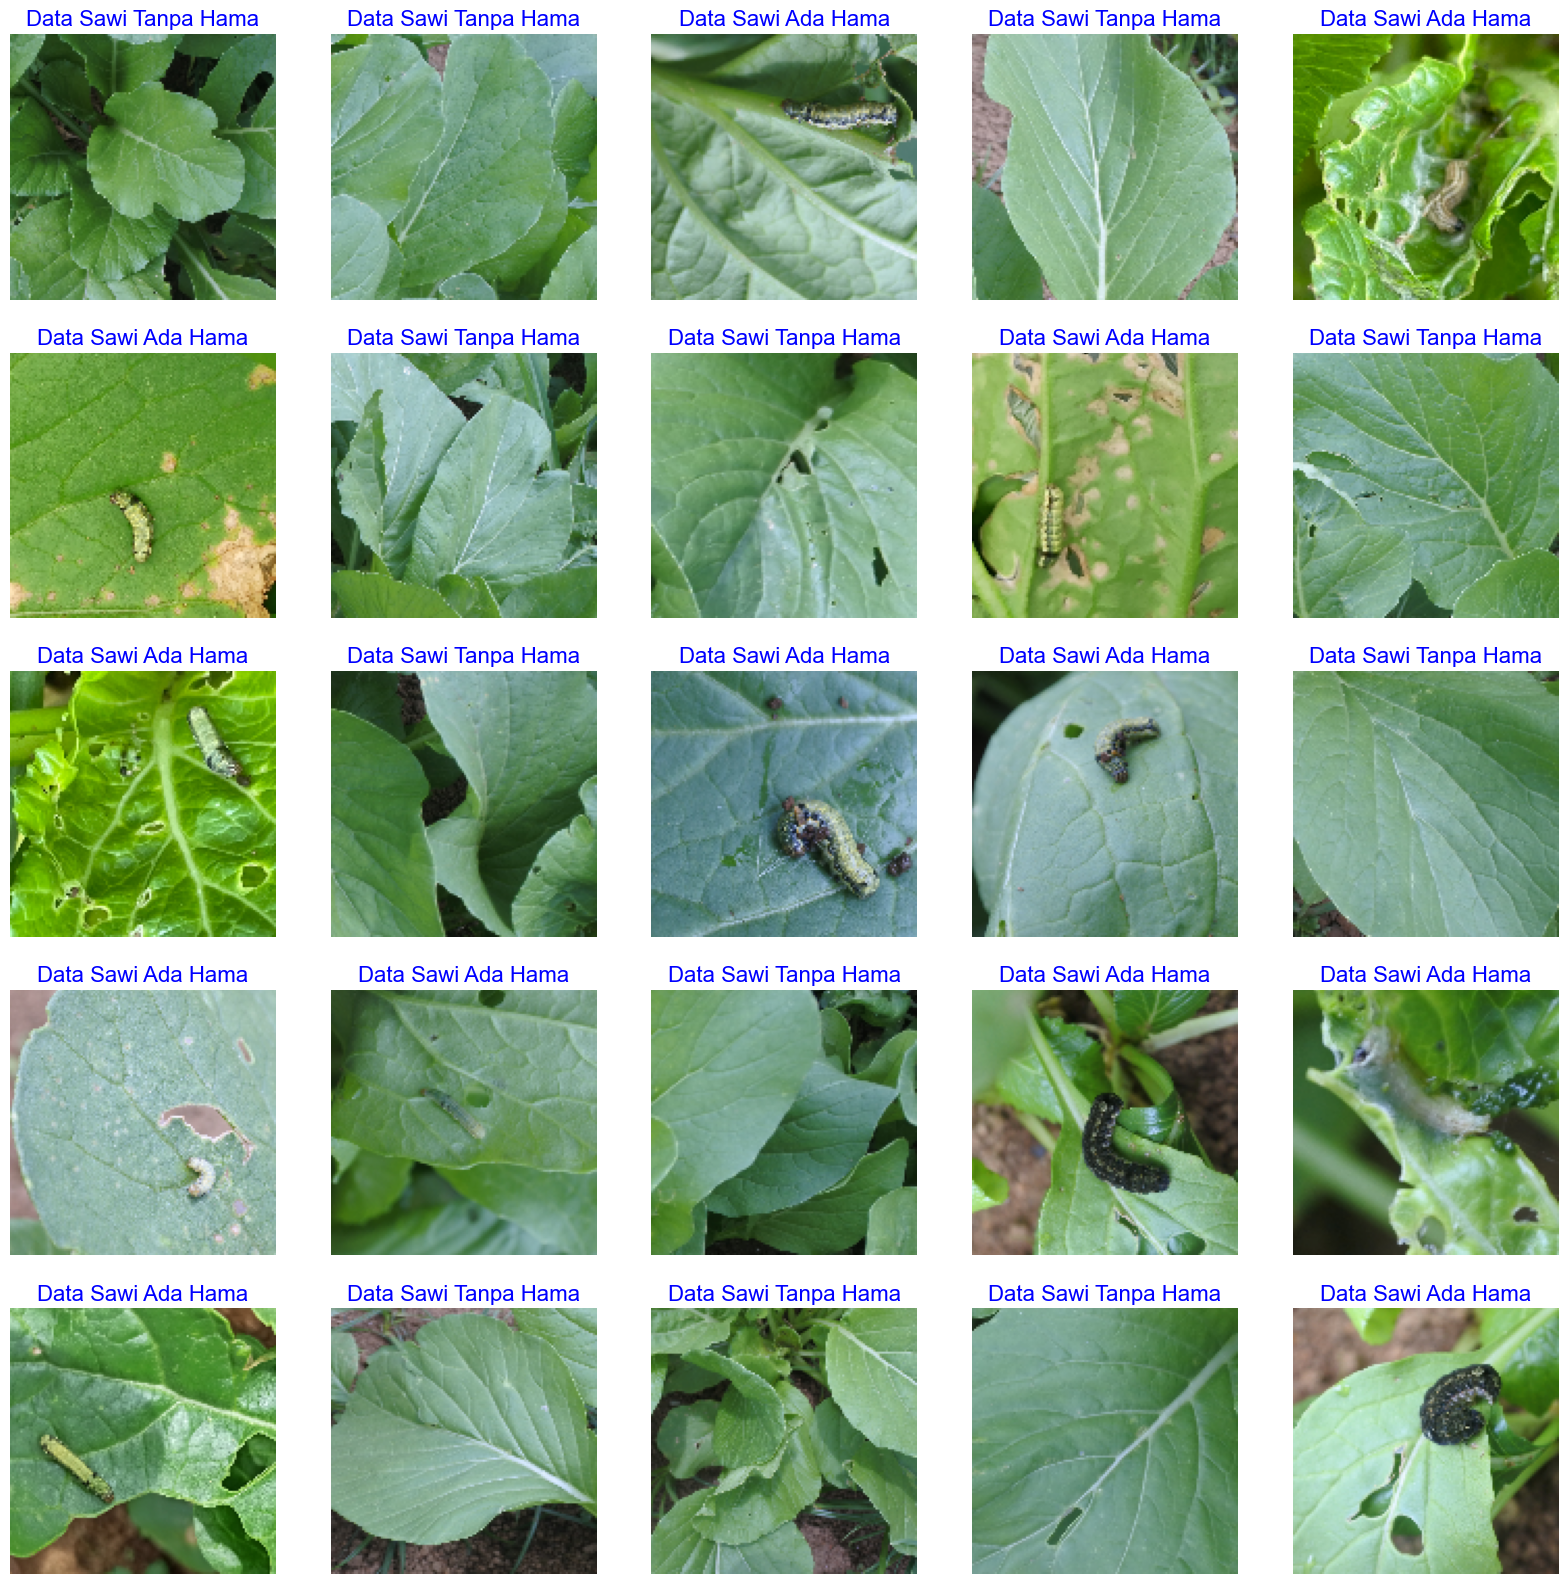

In [7]:
#menampilkan image samples
show_image_samples(train_gen)

#Pembuatan model dasar

In [8]:
# Membuat model dasar menggunakan arsitektur Xception yang sudah dilatih sebelumnya
base_model = tf.keras.applications.Xception(
    include_top=False,              # Tidak menyertakan lapisan klasifikasi (head) pada model
    weights="imagenet",             # Menggunakan bobot yang sudah dilatih sebelumnya dengan dataset ImageNet
    input_tensor=Input(shape=(128,128,3))  # Menentukan bentuk input tensor sebagai (tinggi, lebar, saluran) yaitu (128,128,3)
)

In [9]:
#ringkasan model
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 31,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

#Pembangunan dan Kompilasi Model Klasifikasi

In [10]:
# Membuat model dasar tidak dapat dilatih
base_model.trainable = False

In [13]:
# Menentukan nama model
model_name = 'DetectionPest'

# Mencetak pesan yang menunjukkan bahwa model sedang dibangun dengan base_model
print("Building model with", base_model)

# Membangun model Sequential baru
model = tf.keras.Sequential([
            # Menggunakan base_model sebagai lapisan pertama
            base_model,
            
            # Menambahkan lapisan konvolusi dengan 32 filter, ukuran kernel 3x3, padding 'same', dan aktivasi ReLU
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            
            # Menambahkan lapisan max pooling dengan ukuran pool 2x2 dan strides 2
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            
            # Menambahkan lapisan dropout dengan rate 0.5 untuk mencegah overfitting
            tf.keras.layers.Dropout(rate=0.5),

            # Menambahkan lapisan flatten untuk meratakan output dari lapisan sebelumnya
            tf.keras.layers.Flatten(),
            
            # Menambahkan lapisan dense dengan 2 unit output dan aktivasi softmax untuk klasifikasi
            tf.keras.layers.Dense(2, activation='softmax')
])

# Mengompilasi model dengan optimizer Adam, loss function categorical crossentropy, dan metrik akurasi
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Building model with <Functional name=xception, built=True>


In [14]:
#ringkasan model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,451,594 (81.83 MB)

 Trainable params: 590,114 (2.25 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

#Pelatihan Model

In [15]:
# Menentukan jumlah epoch untuk pelatihan
epochs = 10

# Melatih model menggunakan data pelatihan dan data validasi
history = model.fit(
    x=train_gen,            # Generator data pelatihan
    epochs=epochs,          # Jumlah epoch pelatihan
    validation_data=valid_gen  # Generator data validasi untuk mengevaluasi performa model pada data validasi di setiap epoch
)

Epoch 1/10


d:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8111 - loss: 0.4173 - val_accuracy: 0.9300 - val_loss: 0.1693
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9451 - loss: 0.1328 - val_accuracy: 0.9400 - val_loss: 0.1887
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9652 - loss: 0.1014 - val_accuracy: 0.9400 - val_loss: 0.2176
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9657 - loss: 0.0775 - val_accuracy: 0.9600 - val_loss: 0.1152
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9867 - loss: 0.0501 - val_accuracy: 0.9400 - val_loss: 0.1462
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9880 - loss: 0.0337 - val_accuracy: 0.9400 - val_loss: 0.2262
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9918 - loss: 0.0253 - val_accuracy: 0.9700 - val_loss: 0.1418
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9900 - loss: 0.0355 - val_accuracy: 0.9500 - val_loss: 0.1839
Epo

#Fungsi untuk Mencetak Pesan dengan Warna

In [17]:
# Mendefinisikan fungsi untuk mencetak pesan teks dengan warna foreground dan background yang ditentukan
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # Mencetak txt_msg dengan warna foreground dan background yang ditentukan
    # txt_msg adalah teks yang akan dicetak
    # fore_tupple adalah tuple warna foreground (r, g, b)
    # back_tupple adalah tuple warna background (r, g, b)

    # Mengurai tuple warna foreground menjadi komponen merah, hijau, dan biru
    rf, gf, bf = fore_tupple

    # Mengurai tuple warna background menjadi komponen merah, hijau, dan biru
    rb, gb, bb = back_tupple

    # Membuat string format untuk pesan yang akan dicetak
    msg = '{0}' + txt_msg

    # Membuat kode ANSI untuk warna dengan foreground dan background yang ditentukan
    mat = '\33[38;2;' + str(rf) + ';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' + str(gb) + ';' + str(bb) + 'm'

    # Mencetak pesan dengan format warna yang ditentukan
    print(msg.format(mat), flush=True)

    # Mengembalikan warna teks ke default (biasanya hitam)
    print('\33[0m', flush=True)

    return

#Visualisasi Hasil Pelatihan Model

In [18]:
# Mendefinisikan fungsi untuk memplot data pelatihan dan validasi
def tr_plot(tr_data, start_epoch):
    # Mengambil data akurasi dan loss dari hasil pelatihan
    tacc = tr_data.history['accuracy']        # Akurasi pelatihan
    tloss = tr_data.history['loss']           # Loss pelatihan
    vacc = tr_data.history['val_accuracy']    # Akurasi validasi
    vloss = tr_data.history['val_loss']       # Loss validasi

    # Menghitung jumlah epoch total
    Epoch_count = len(tacc) + start_epoch
    Epochs = []

    # Membuat daftar epoch yang dimulai dari start_epoch
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    # Menentukan epoch dengan loss validasi terendah dan akurasi validasi tertinggi
    index_loss = np.argmin(vloss)  # Epoch dengan loss validasi terendah
    val_lowest = vloss[index_loss] 
    index_acc = np.argmax(vacc)    # Epoch dengan akurasi validasi tertinggi
    acc_highest = vacc[index_acc]

    # Menentukan gaya plot
    plt.style.use('fivethirtyeight')

    # Label untuk titik terbaik
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    # Membuat subplot dengan dua grafik
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Grafik pertama: Training Loss dan Validation Loss
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Grafik kedua: Training Accuracy dan Validation Accuracy
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Menyesuaikan tata letak subplot
    plt.tight_layout()

    # Menampilkan plot
    plt.show()


In [19]:
# Mendefinisikan fungsi untuk mencetak informasi dan visualisasi hasil prediksi
def print_info(test_gen, preds, print_code, save_dir, subject):
    # Mengambil informasi dari generator tes
    class_dict = test_gen.class_indices
    labels = test_gen.labels
    file_names = test_gen.filenames
    
    # Inisialisasi variabel untuk menyimpan informasi kesalahan
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []

    # Membuat dictionary terbalik untuk pemetaan kelas
    for key, value in class_dict.items():
        new_dict[value] = key

    # Menyimpan dictionary kelas sebagai file teks di save_dir
    classes = list(new_dict.values())
    dict_as_text = str(new_dict)
    dict_name = subject + '-' + str(len(classes)) + '.txt'
    dict_path = os.path.join(save_dir, dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    
    # Menghitung dan menyimpan kesalahan prediksi
    errors = 0
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = labels[i]
        if pred_index != true_index:
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors += 1
        y_pred.append(pred_index)
    
    # Mencetak informasi kesalahan jika ada
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class', 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            for i in range(r):
                split1 = os.path.split(error_list[i])
                split2 = os.path.split(split1[0])
                fname = split2[1] + '/' + split1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
    
    # Visualisasi kesalahan per kelas jika ada kesalahan
    if errors > 0:
        plot_bar = []
        plot_class = []
        for key, value in new_dict.items():
            count = error_indices.count(key)
            if count != 0:
                plot_bar.append(count)
                plot_class.append(value)
        fig = plt.figure()
        fig.set_figheight(len(plot_class) / 3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x)
        plt.title('Errors by Class on Test Set')
    
    # Membuat dan menampilkan confusion matrix jika jumlah kelas <= 30
    y_true = np.array(labels)
    y_pred = np.array(y_pred)
    if len(classes) <= 30:
        cm = confusion_matrix(y_true, y_pred)
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length) + .5, classes, rotation=90)
        plt.yticks(np.arange(length) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    # Mencetak classification report
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)


#Evaluasi dan Visualisasi Hasil Prediksi

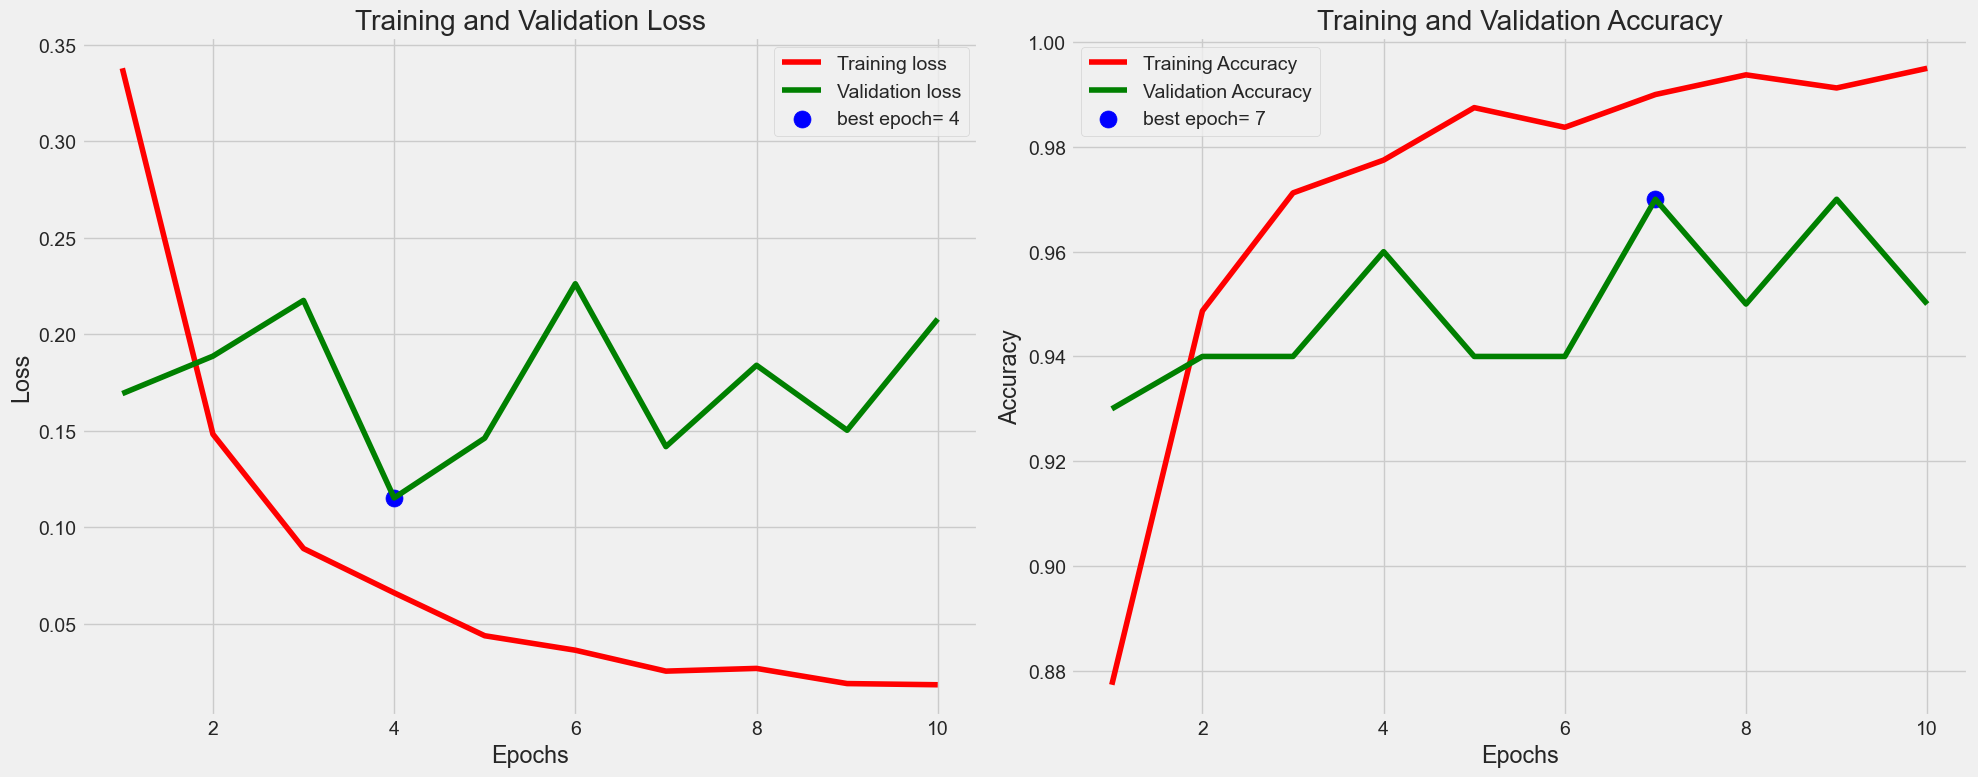

d:\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 962ms/step - accuracy: 0.9800 - loss: 0.0888
accuracy on the test set is 98.00 %



In [20]:
# Menampilkan plot hasil pelatihan dan validasi
tr_plot(history, 0)

# Menentukan direktori penyimpanan dan subjek
save_dir = r'./'
subject = 'pest'

# Mengevaluasi model pada dataset tes
# Menghitung akurasi dari model pada dataset tes
acc = model.evaluate(test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1] * 100

# Menyusun pesan tentang akurasi tes
msg = f'accuracy on the test set is {acc:5.2f} %'

# Mencetak pesan akurasi dengan format warna
print_in_color(msg, (0, 255, 0), (55, 65, 80))

# Menentukan nama file untuk menyimpan model
save_id = str(model_name + '-' + subject + '-' + str(acc)[:str(acc).rfind('.') + 3] + '.h5')

# Menentukan lokasi penyimpanan model
save_loc = os.path.join(save_dir, save_id)

# Menyimpan model ke file dengan nama yang ditentukan
model.save(save_loc)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step


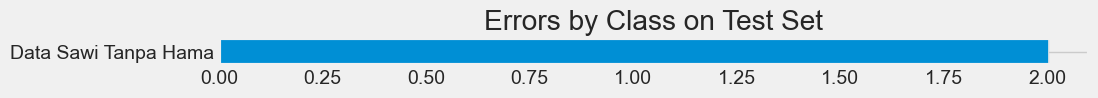

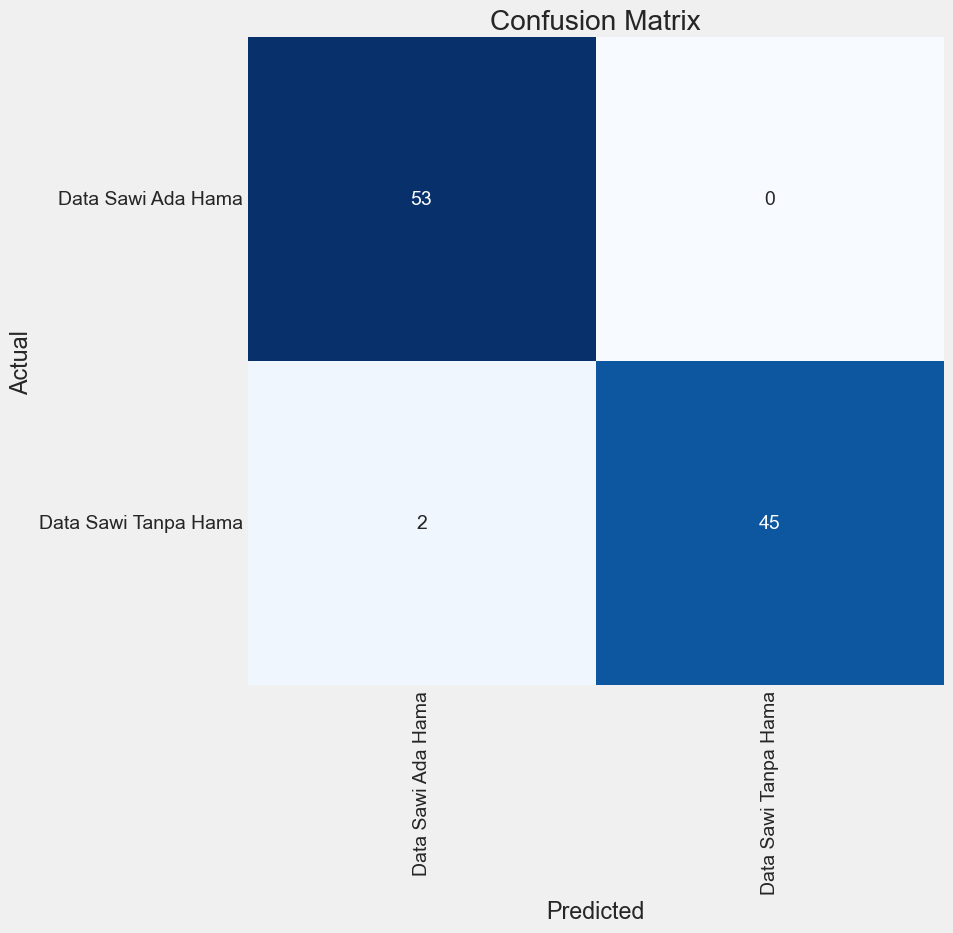

Classification Report:
----------------------
                       precision    recall  f1-score   support

  Data Sawi Ada Hama       0.96      1.00      0.98        53
Data Sawi Tanpa Hama       1.00      0.96      0.98        47

            accuracy                           0.98       100
           macro avg       0.98      0.98      0.98       100
        weighted avg       0.98      0.98      0.98       100



In [21]:
# Menentukan apakah informasi kesalahan akan dicetak (0 berarti tidak mencetak)
print_code = 0

# Menghasilkan prediksi dari model menggunakan data dari test_gen
preds = model.predict(test_gen)

# Menampilkan informasi prediksi, termasuk kesalahan jika ada
# Menggunakan fungsi print_info untuk mencetak informasi prediksi
print_info(test_gen, preds, print_code, save_dir, subject)
